# Replication of paper "Approximate Bayesian computational methods" (2011)

In [20]:
using Distributions, StatsPlots, Plots, StatsBase, LinearAlgebra, KernelDensity
using LaTeXStrings
using SymPy
using VegaLite
using DataFrames
pyplot()

Plots.PyPlotBackend()

### **Alorithm 1** - Likelihood-free rejection sampler 1
Let's use sampling from Uniform with binomial likelihood function to illustrate this algorithm.

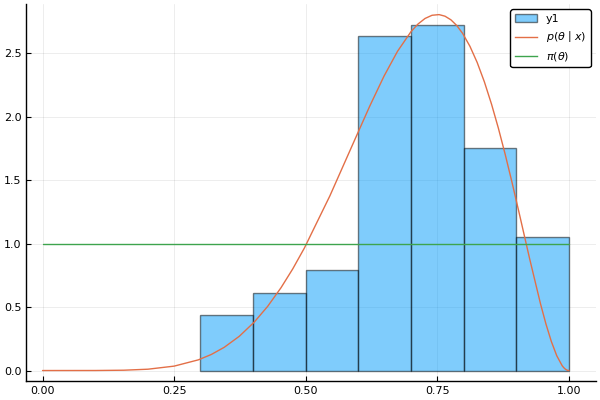

In [2]:
n, x = 8, 6
N = 1000

# Sample θ' from prior π(θ)
# Generate z from p(.|θ')
theta_s = rand(Beta(1,1),N)
z       = rand.(Binomial.(n,theta_s))
theta_a = theta_s[z .== x];
v = collect(range(0, stop=1, length=N));

histogram(theta_a,normalize=true,alpha=0.5)
plot!(Beta(x+1,n-x+1),label=L"p(\theta \mid x)")
plot!(Beta(1,1), label =L"\pi(\theta)")

### **Alorithm 2** - Likelihood-free rejection sampler 2

Let's write the functions for calculating the distances between the variables.

##### a) **Moving Average Model**

In [116]:
MA(current, u,t) = u[current+2] + u[current + 1] * t[1] + u[current] * t[2]

function genMA(u,t,n,N)
    z = zeros(N,n)
        for i=1:N
            z[i,:] = MA.((1:n),Ref(u[i,:]),Ref(t[i,:]))
        end
    return z
end

genMA (generic function with 1 method)

##### b) **Synthetic Dataset**
###### Moving Average model (MA)
$y_k = u_k + \sum_{i=1}^q \theta_i u_{k-i}$

$y \sim MA(q)$

$(\theta_1,\theta_2) =(0.6,0.2)$,sample size of 100.

In [117]:
using Random
Random.seed!(3)
theta = [0.6;0.2]
n     = 100
u     = randn(n+2)
y     = MA.((1:n),Ref(u),Ref(theta));
# y     = genMA(u',theta',n,1)

##### c) **Distance Functions and Suffient Statistics**

In [118]:
raw_distance(y,z)         = sqrt(sum((y-z).^2))
function abcautocov_distance(y,z)
    ay = 0
    az = 0
    for i = 2:length(y)
        ay +=y[i]*y[i-1]
        az +=z[i]*z[i-1]
    end
    ay2 = 0
    az2 = 0
    for i = 3:length(y)
        ay2 +=y[i]*y[i-2]
        az2 +=z[i]*z[i-2]
    end
#     rho = (ay - az)^2+(ay2 - az2)^2 +(sum(y.^2)- sum(z.^2))^2 # Codigo com lag = 0 apresentou melhor resultado aparentemente
    rho = (ay - az)^2+(ay2 - az2)^2
    return rho
end


abcautocov_distance (generic function with 1 method)

Utilizando covarianca com lags 0,

##### d) **Triangular Sampling**
Using rejection sampling to sample uniformly in a triangle

In [119]:
function rand_TriUniform(N=1)
    trisample = zeros(N,2)
    count = 0
    while count < N
        theta = [4*rand()-2;2*rand()-1]
        if (theta[1]>-2 && theta[1]<2) && (sum(theta)>-1) && (theta[1]-theta[2] < 1)
            count+=1
            trisample[count,:] = theta
        end
    end
    return trisample
end

rand_TriUniform (generic function with 2 methods)

##### e) **Running Algorithm 2**

In [120]:
# Random.seed!(1)
N = 10^6        # number of trials
n = length(y) # sample size
theta_s = rand_TriUniform(N)
u       = randn(N,n+2)
z       = genMA(u,theta_s,n,N);

In [121]:
autocov_vectorize(z)    = abcautocov_distance(y,z)
dist_vectorize(z)       = raw_distance(y,z)
rho_autocov = mapslices(autocov_vectorize, z, dims =2)[:];
rho_dist    = mapslices(dist_vectorize, z, dims =2)[:];

epsilon10e4_autocov = quantile(rho_autocov,0.1/100)
epsilon10e4_dist    = quantile(rho_dist,0.1/100)

theta_ac_auto = theta_s[rho_autocov .< epsilon10e4_autocov,:];
theta_ac_dist = theta_s[rho_dist    .< epsilon10e4_dist,:];

In [122]:
function Ger_Simga(θ1,θ2, y)
    Σ = zeros(100,100)
    for i=1:length(y)
        if i == 1
            Σ[i,i]   = 1 + θ1^2 + θ2^2
            Σ[i,i+1] = θ1 + θ1*θ2
            Σ[i,i+2] = θ2
        elseif i == 2
            Σ[i,i-1] = θ1 + θ1*θ2
            Σ[i,i]   = 1 + θ1^2 + θ2^2
            Σ[i,i+1] = θ1 + θ1*θ2
            Σ[i,i+2] = θ2
        elseif i == 99
            Σ[i,i-2] = θ2
            Σ[i,i-1] = θ1 + θ1*θ2
            Σ[i,i]   = 1 + θ1^2 + θ2^2
            Σ[i,i+1] = θ1 + θ1*θ2
        elseif i == 100
            Σ[i,i-2] = θ2
            Σ[i,i-1] = θ1 + θ1*θ2
            Σ[i,i]   = 1 + θ1^2 + θ2^2
        else
            Σ[i,i-2] = θ2
            Σ[i,i-1] = θ1 + θ1*θ2
            Σ[i,i]   = 1 + θ1^2 + θ2^2
            Σ[i,i+1] = θ1 + θ1*θ2
            Σ[i,i+2] = θ2
        end
    end

    return Σ
end

Ger_Simga (generic function with 1 method)

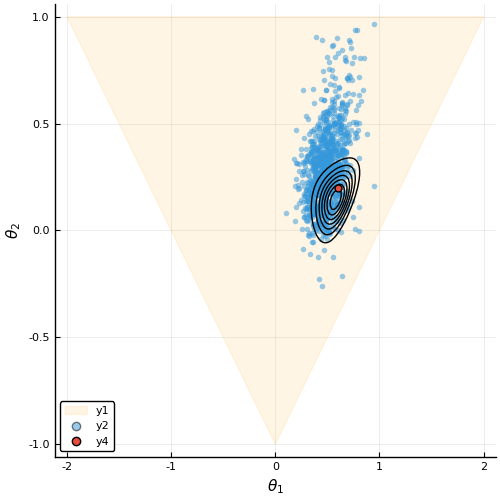

In [123]:
plot(Plots.P2[(0,-1),(-2,1),(2,1),(0,-1)],fill=true,color=:orange,alpha=0.1)
scatter!(theta_ac_auto[:,1],theta_ac_auto[:,2],xlims=[-2,2],alpha=0.5,markerstrokewidth=0,c="#3498db")


# Contour Plot - True posterior
gθ1      = -0:0.02:1
gθ2      = -0.5:0.02:0.5
gridθ1   = repeat(reshape(gθ1, 1, :), length(gθ2), 1)
gridθ2   = repeat(gθ2, 1, length(gθ1))
mamvn(θ1,θ2) = pdf(MvNormal(zeros(100),Ger_Simga(θ1,θ2,y)),y)
Z = map(mamvn, gridθ1, gridθ2)
p1 = contour!(gθ1,gθ2, mamvn, fill=false,c=:black,levels=8,
    xlabel=L"\theta_1", ylabel=L"\theta_2",colorbar=false)

scatter!([theta[1]],[theta[2]],markersize=5,c="#e74c3c",size=(500,500))

### **Metropolis-Hasting Estimating Marginal**

In [125]:
# M-H
x1 = rand()
x2 = rand() - 0.5
burnin = 1_000
steps = 100_000
C = zeros(steps,2)
Xprevious   = [0;0]

for i=1:steps
    Xnew        = Xprevious + randn(2)*0.1
    alpha = minimum([1,exp(log(mamvn(Xnew[1],Xnew[2])) - log(mamvn(Xprevious[1],Xprevious[2])))])
#     println(1 - alpha, Xnew)
    if rand() < (1 - alpha) # Reject
        Xnew = Xprevious
    end
    C[i,:] = Xnew
    Xprevious = Xnew
end

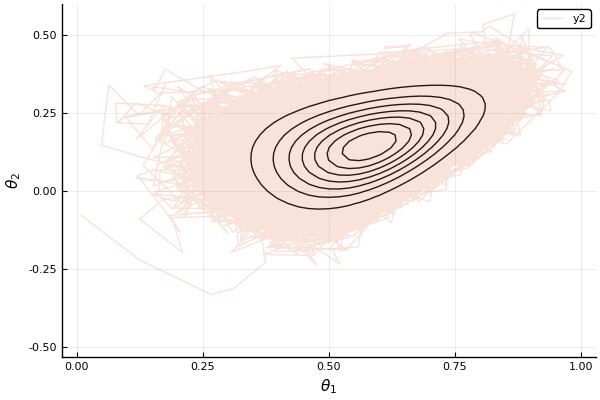

In [126]:
contour(gθ1,gθ2, mamvn, fill=false,c=:black,levels=8,
    xlabel=L"\theta_1", ylabel=L"\theta_2",colorbar=false)
plot!(C[:,1],C[:,2],alpha=0.2)

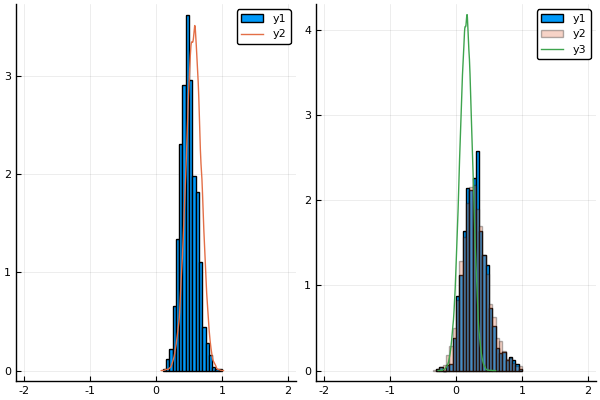

In [133]:
epsilon10e4_autocov = quantile(rho_autocov,0.1/100)
epsilon10e4_dist    = quantile(rho_dist,0.1/100)
theta_ac_auto = theta_s[rho_autocov .< epsilon10e4_autocov,:];
theta_ac_dist = theta_s[rho_dist    .< epsilon10e4_dist,:];

epsilon10e3_autocov = quantile(rho_autocov,1/100)
epsilon10e3_dist    = quantile(rho_dist,1/100)
theta_ac_auto10e3 = theta_s[rho_autocov .< epsilon10e3_autocov,:];
theta_ac_dist10e3 = theta_s[rho_dist    .< epsilon10e3_dist,:];

epsilon10e2_autocov = quantile(rho_autocov,10/100)
epsilon10e2_dist    = quantile(rho_dist,10/100)
theta_ac_auto10e2 = theta_s[rho_autocov .< epsilon10e2_autocov,:];
theta_ac_dist10e2 = theta_s[rho_dist    .< epsilon10e2_dist,:];


MH = C[1_000:end,:]
θ1_marginal =  maximum(MH,dims=2)
θ2_marginal =  minimum(MH,dims=2)
h1 = histogram(theta_ac_auto[:,1],normalize=true,xlims=[-2,2])
# histogram!(theta_ac_auto10e3[:,1],normalize=true,xlims=[-2,2],alpha=0.3)
# histogram!(theta_ac_auto10e2[:,1],normalize=true,xlims=[-2,2],alpha=0.3)
d1 = density!(θ1_marginal)
h2 = histogram(theta_ac_auto[:,2],normalize=true,xlims=[-1,1])
histogram!(theta_ac_auto10e3[:,2],normalize=true,xlims=[-2,2],alpha=0.3)
# histogram!(theta_ac_auto10e2[:,1],normalize=true,xlims=[-2,2],alpha=0.3)
d2 = density!(θ2_marginal)
plot(d1,d2,layout=2)